this script is for use locally in your machine, if your machine has no Nvidia GPU

In [1]:
from keras.utils import image_dataset_from_directory
import pandas as pd
import os
import cv2
import numpy as np
from re import sub
import tensorflow as tf
from keras import metrics

import matplotlib.colors as mcolors

from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense


from keras.optimizers import Adam
from keras.preprocessing import image

import matplotlib.pyplot as plt
from keras import models
from keras import  preprocessing
print("Done importing packages!")

2022-07-25 15:27:02.126580: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-25 15:27:02.126609: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Done importing packages!


In [2]:
BATCH_SIZE = 32
IMG_SIZE = (240, 240)

In [4]:
#data_dir = "../input/plantvillage-dataset/color"
data_dir = "plantville"
train_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.2,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "training",
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.2,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "validation",
                                             image_size=IMG_SIZE)

Found 22787 files belonging to 15 classes.
Using 18230 files for training.


2022-07-25 15:28:14.854472: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-25 15:28:14.854543: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (miliandeb): /proc/driver/nvidia/version does not exist
2022-07-25 15:28:14.859588: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 22787 files belonging to 15 classes.
Using 4557 files for validation.


In [5]:
class_names = train_dataset.class_names
num_classes = len(class_names)
for i in range(1, num_classes + 1):
    print(str(i) + ". ", class_names[i - 1])

1.  Pepper__bell___Bacterial_spot
2.  Pepper__bell___healthy
3.  Potato___Early_blight
4.  Potato___Late_blight
5.  Potato___healthy
6.  Tomato___Bacterial_spot
7.  Tomato___Early_blight
8.  Tomato___Late_blight
9.  Tomato___Leaf_Mold
10.  Tomato___Septoria_leaf_spot
11.  Tomato___Spider_mites Two-spotted_spider_mite
12.  Tomato___Target_Spot
13.  Tomato___Tomato_Yellow_Leaf_Curl_Virus
14.  Tomato___Tomato_mosaic_virus
15.  Tomato___healthy


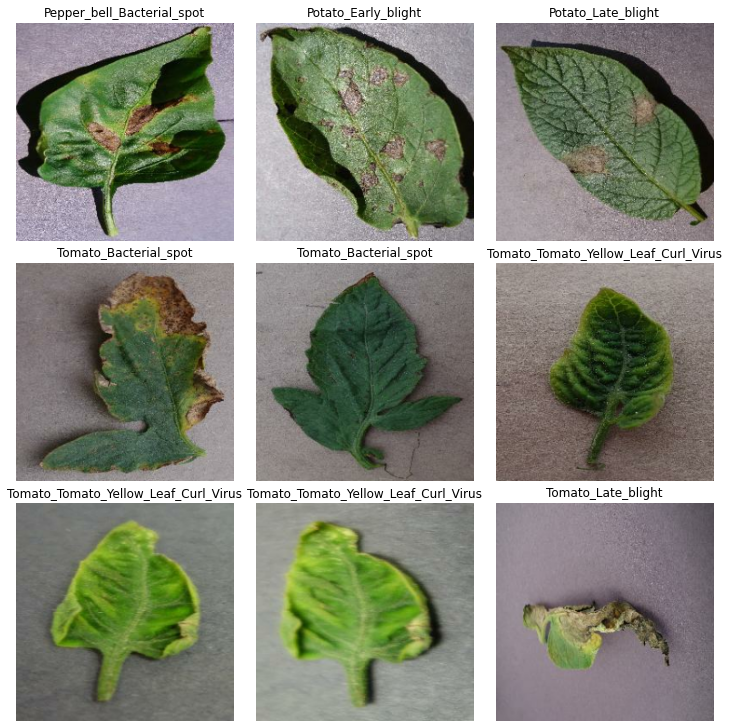

In [6]:
fig = plt.figure(figsize=(10, 10), constrained_layout=True)
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        title = sub(r"[_]+","_",class_names[np.argmax(labels[i])])
        plt.title(title)
        plt.axis("off")

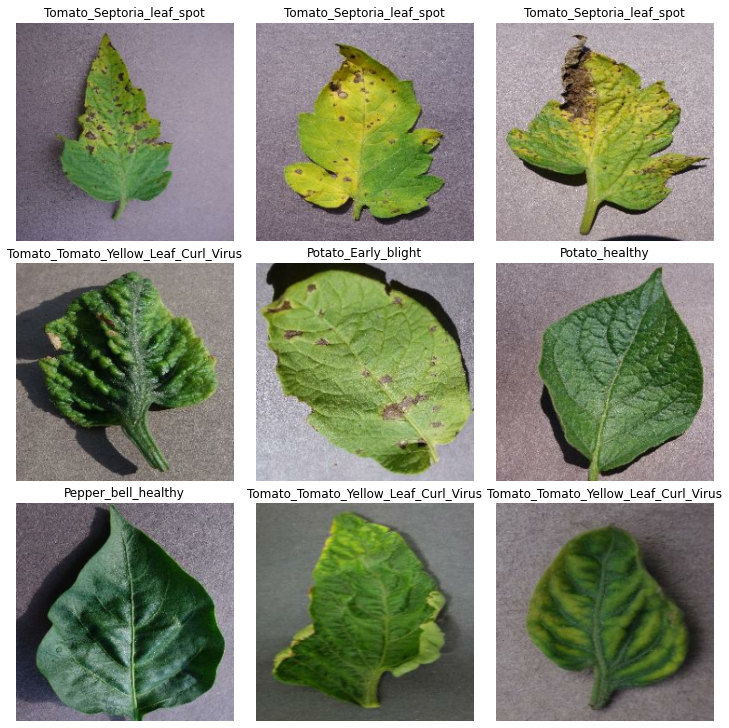

In [7]:
plt.figure(figsize=(10, 10), constrained_layout=True)
for images, labels in validation_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        title = sub(r"[_]+","_",class_names[np.argmax(labels[i])])
        plt.title(title)
        plt.axis("off")

In [8]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 115
Number of test batches: 28


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  tf.keras.layers.experimental.preprocessing.RandomCrop(200, 200),
  tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(factor=0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(factor=0.2),
  tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.4),
  #tf.keras.layers.experimental.preprocessing.Resizing(50, 50),
  #tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255),

])

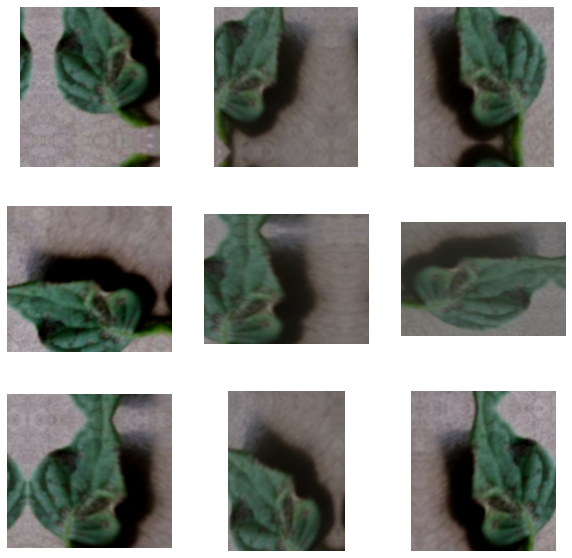

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [12]:
augmented_image

<tf.Tensor: shape=(1, 187, 169, 3), dtype=float32, numpy=
array([[[[137.366   , 128.5748  , 132.74344 ],
         [140.07771 , 130.4375  , 132.90813 ],
         [142.01245 , 131.20554 , 131.34276 ],
         ...,
         [152.43024 , 143.77971 , 148.22969 ],
         [151.35217 , 142.70163 , 147.15161 ],
         [152.37643 , 143.72589 , 148.17587 ]],

        [[137.94989 , 129.28165 , 133.69618 ],
         [136.3909  , 127.42952 , 131.25778 ],
         [135.62811 , 125.64586 , 127.43242 ],
         ...,
         [153.50418 , 144.85365 , 149.30363 ],
         [147.90736 , 139.25684 , 143.70682 ],
         [146.39459 , 137.74408 , 142.19405 ]],

        [[137.81538 , 129.16408 , 133.6125  ],
         [133.57404 , 124.87294 , 129.22182 ],
         [131.80833 , 122.6593  , 126.11229 ],
         ...,
         [151.01913 , 142.36859 , 146.81857 ],
         [147.40608 , 138.75558 , 143.20554 ],
         [148.41986 , 139.76935 , 144.21933 ]],

        ...,

        [[135.19147 , 124.03994 , 

In [13]:
first_image

<tf.Tensor: shape=(240, 240, 3), dtype=float32, numpy=
array([[[127.933334, 119.933334, 117.933334],
        [127.933334, 119.933334, 117.933334],
        [127.933334, 119.933334, 117.933334],
        ...,
        [125.08328 , 119.08328 , 123.08328 ],
        [132.31009 , 126.31008 , 130.31009 ],
        [148.28012 , 142.28012 , 146.28012 ]],

       [[125.9     , 117.9     , 115.9     ],
        [125.9     , 117.9     , 115.9     ],
        [125.9     , 117.9     , 115.9     ],
        ...,
        [133.78339 , 127.78339 , 131.78339 ],
        [139.91005 , 133.91005 , 137.91005 ],
        [143.40002 , 137.40002 , 141.40002 ]],

       [[125.166664, 117.166664, 115.166664],
        [125.166664, 117.166664, 115.166664],
        [125.166664, 117.166664, 115.166664],
        ...,
        [147.58347 , 141.58347 , 145.58347 ],
        [154.01671 , 148.01671 , 152.01671 ],
        [149.18329 , 143.18329 , 147.18329 ]],

       ...,

       [[128.32782 , 118.32782 , 117.32782 ],
        [128.

In [14]:
def plot_metrics(history):
  colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
  metrics = ['loss', 'auc', 'precision', 'recall']
  plt.figure(figsize=(20,10))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [15]:
METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.CategoricalAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc')
]

In [16]:
IMG_SHAPE = IMG_SIZE + (3,)

In [17]:
preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input

In [18]:
# base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                                include_top=False,
#                                                weights='imagenet')
base_model = tf.keras.applications.InceptionResNetV2(
                                include_top=False,
                                weights="imagenet",
                                input_shape=IMG_SHAPE,
                            )

219055592/219055592 [==============================] - 36s 0us/step


In [19]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2022-07-25 15:32:13.170497: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 112140288 exceeds 10% of free system memory.
2022-07-25 15:32:13.375124: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 112140288 exceeds 10% of free system memory.
2022-07-25 15:32:13.404370: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 112140288 exceeds 10% of free system memory.
2022-07-25 15:32:13.503740: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 77070336 exceeds 10% of free system memory.
2022-07-25 15:32:13.796414: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 77070336 exceeds 10% of free system memory.


(32, 6, 6, 1536)


In [33]:
base_model.trainable = True

In [34]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

print(feature_batch_average.shape)

(32, 1536)


In [35]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 15)


In [36]:
inputs = tf.keras.Input(shape=(240, 240, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [37]:
print(inputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 240, 240, 3), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")


In [38]:
print(outputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), name='dense_1/Softmax:0', description="created by layer 'dense_1'")


In [39]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=METRICS)

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [40]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 200, 200, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 200, 200, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 200, 200, 3)      0         
 bda)                                                            
                                                                 
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                           

In [41]:
len(model.trainable_variables)

490

In [42]:
initial_epochs = 10

In [43]:
len(train_dataset)

570

In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


/usr/local/lib/python3.9/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


139/570 [======>.......................] - ETA: 1:25:49 - loss: 2.6303 - tp: 15.0000 - fp: 40.0000 - tn: 62232.0000 - fn: 4433.0000 - accuracy: 0.2154 - precision: 0.2727 - recall: 0.0034 - auc: 0.6544

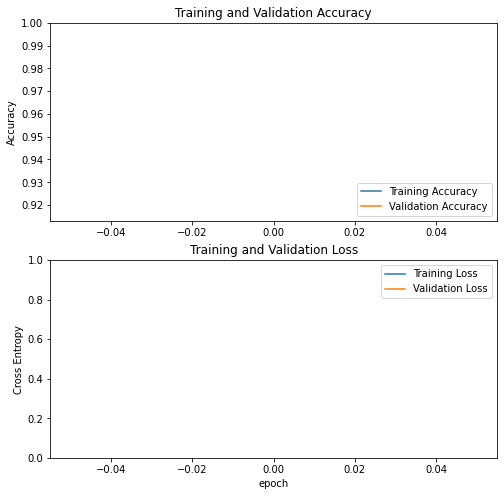

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

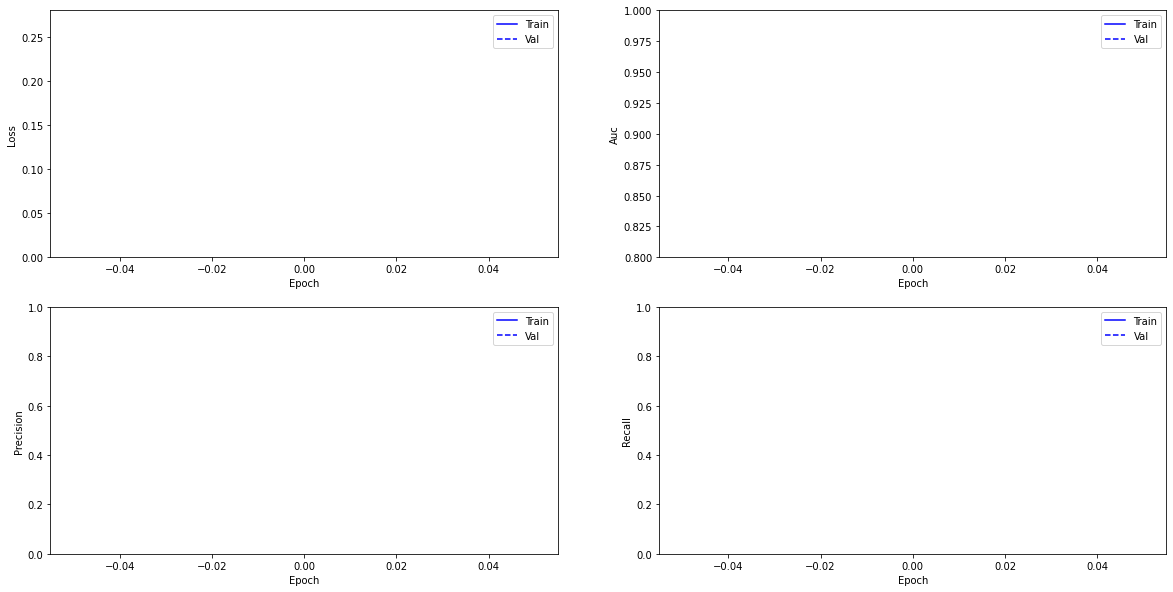

In [ ]:
plot_metrics(history)

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 700

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  780


In [ ]:
fine_tuning_learning_rate = 1e-5
model.compile(optimizer=tf.keras.optimizers.Adam(lr=fine_tuning_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=METRICS)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 240, 240, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 240, 240, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 240, 240, 3)      0         
 a)                                                              
                                                                 
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                             

In [ ]:
len(model.trainable_variables)

52

In [ ]:
#fine_tune_epochs = 15
fine_tune_epochs = 1
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


54/54 [==============================] - 779s 13s/step - loss: 0.1436 - tp: 1973.0000 - fp: 78.0000 - tn: 77067.0000 - fn: 112.0000 - accuracy: 0.9544 - precision: 0.9620 - recall: 0.9463 - auc: 0.9997 - val_loss: 0.0804 - val_tp: 354.0000 - val_fp: 9.0000 - val_tn: 13496.0000 - val_fn: 11.0000 - val_accuracy: 0.9726 - val_precision: 0.9752 - val_recall: 0.9699 - val_auc: 0.9999
Epoch 2/2
54/54 [==============================] - 713s 13s/step - loss: 0.0816 - tp: 1672.0000 - fp: 41.0000 - tn: 63599.0000 - fn: 48.0000 - accuracy: 0.9756 - precision: 0.9761 - recall: 0.9721 - auc: 0.9999 - val_loss: 0.0441 - val_tp: 362.0000 - val_fp: 3.0000 - val_tn: 13502.0000 - val_fn: 3.0000 - val_accuracy: 0.9918 - val_precision: 0.9918 - val_recall: 0.9918 - val_auc: 1.0000


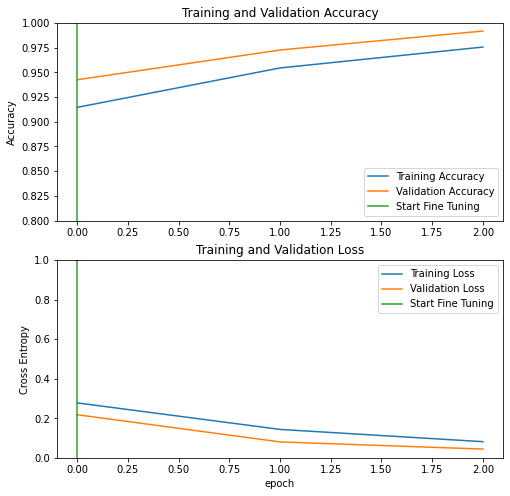

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']



plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy')
plt.show()

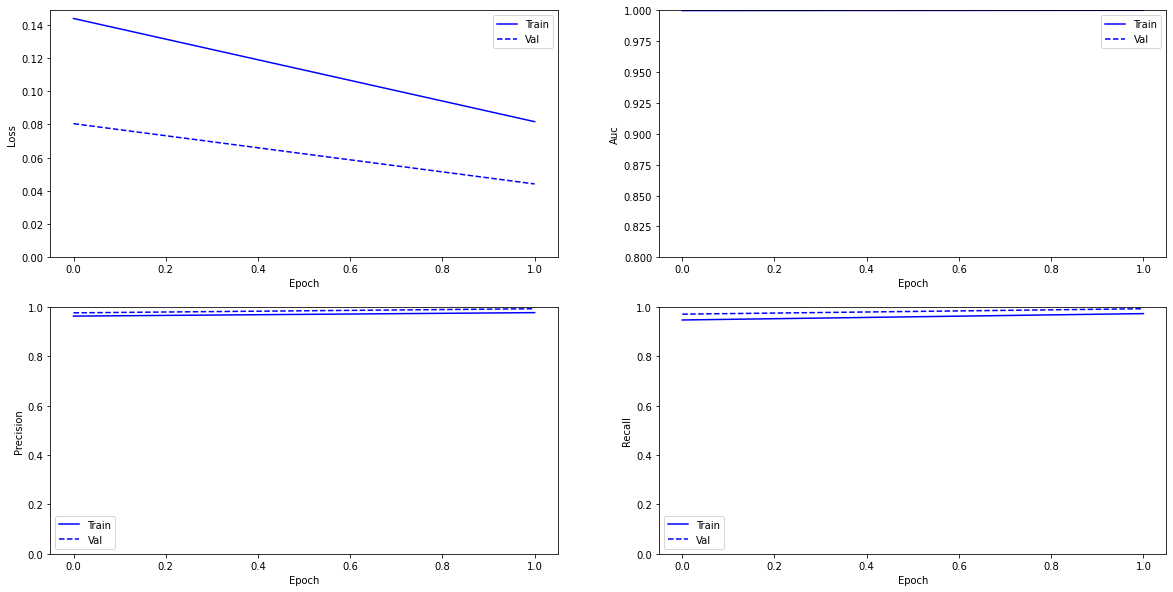

In [ ]:
plot_metrics(history_fine)

In [ ]:
result = model.evaluate(test_dataset)

2/2 [==============================] - 19s 9s/step - loss: 0.0307 - tp: 63.0000 - fp: 1.0000 - tn: 2367.0000 - fn: 1.0000 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 1.0000


In [ ]:
result = model.evaluate(validation_dataset)

12/12 [==============================] - 104s 9s/step - loss: 0.0373 - tp: 363.0000 - fp: 2.0000 - tn: 13503.0000 - fn: 2.0000 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 1.0000


In [ ]:
print(len(test_dataset))

2


In [ ]:
print(len(validation_dataset))

12


In [ ]:
print(len(train_dataset))

54


In [ ]:
metrics = ["loss", "tp", "fp", "tn", "fn", "accuracy", "precision", "recall", "auc"]
for i in range(len(result)):
    print("{} : {}".format(metrics[i],round(result[i], 3)))

loss : 0.031
tp : 63.0
fp : 1.0
tn : 2367.0
fn : 1.0
accuracy : 0.984
precision : 0.984
recall : 0.984
auc : 1.0


Predictions:
 [35, 19, 35, 35, 17, 17, 35, 35, 19, 35, 17, 17, 18, 17, 35, 18, 35, 35, 35, 35, 19, 35, 18, 35, 19, 35, 18, 35, 35, 35, 19, 35]
Labels:
 [35, 19, 35, 35, 17, 17, 35, 35, 19, 35, 17, 19, 18, 17, 35, 18, 35, 35, 35, 35, 19, 35, 18, 35, 19, 35, 19, 35, 35, 35, 19, 35]


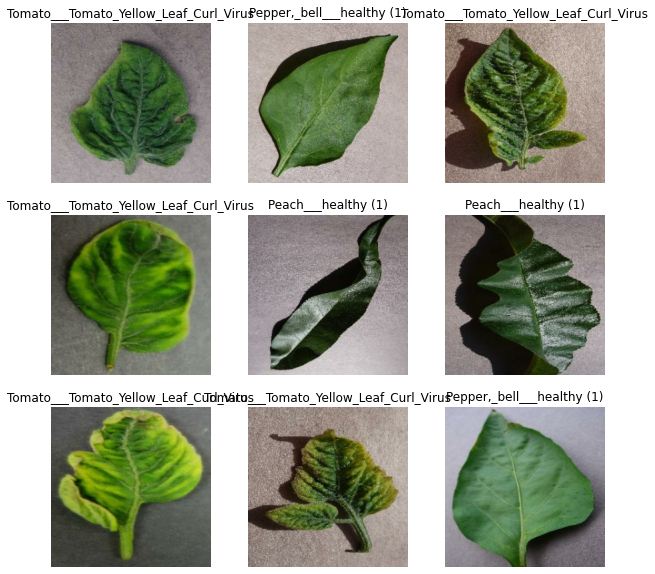

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

predictions = tf.nn.softmax(predictions)
predictions = list(np.argmax(x) for x in predictions.numpy())

print('Predictions:\n', predictions)
print('Labels:\n', list(np.argmax(x) for x in label_batch))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
models.save_model(model, "./inception_v3")

INFO:tensorflow:Assets written to: ./inception_v3/assets


INFO:tensorflow:Assets written to: ./inception_v3/assets
